In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input','/kaggle/working/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/summarized/summarized_cnn_dailymail.csv


In [2]:
import pandas as pd

# Load the dataset with extractive summaries
df = pd.read_csv("/kaggle/input/summarized/summarized_cnn_dailymail.csv")

# Ensure the extractive summaries are clean and not NaN
df = df.dropna(subset=['extractive_summary'])

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save the splits to new CSV files
#train_df.to_csv("/home/jaggu/Major_project/cnn_dailymail_Bart.csv", index=False)
#test_df.to_csv("/home/jaggu/Major_project/cnn_dailymail_Bart.csv", index=False)

In [3]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load the BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")


2025-12-15 10:56:31.650503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765796191.795873      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765796191.839064      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [5]:
from torch.utils.data import Dataset, DataLoader

class CNNDailyMailDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        extractive_summary = self.dataframe.iloc[idx]['extractive_summary']
        highlights = self.dataframe.iloc[idx]['highlights']

        # Tokenize the input and target
        input_encoding = self.tokenizer(
            extractive_summary,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        target_encoding = self.tokenizer(
            highlights,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': target_encoding['input_ids'].squeeze()
        }

# Create the datasets
train_dataset = CNNDailyMailDataset(train_df, tokenizer)
test_dataset = CNNDailyMailDataset(test_df, tokenizer)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

100%|██████████| 1436/1436 [35:22<00:00,  1.48s/it]


Epoch 1/3, Loss: 0.5144783211846039


100%|██████████| 1436/1436 [35:30<00:00,  1.48s/it]


Epoch 2/3, Loss: 0.29676316337125547


100%|██████████| 1436/1436 [35:32<00:00,  1.49s/it]


Epoch 3/3, Loss: 0.26469366466185507


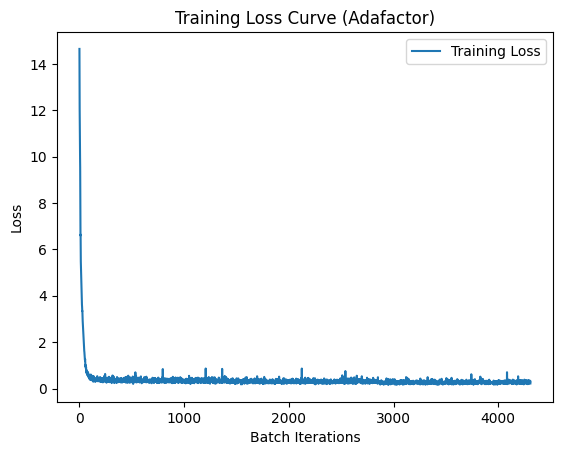

In [6]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- FIX THE IMPORTS FIRST ---
# Since you had import issues, we will try the most likely working path for Adafactor.
# If 'transformers.optimization' doesn't work, try 'transformers.optimization_pytorch'.

try:
    from transformers.optimization import Adafactor
except ImportError:
    try:
        # This path might work if the first one fails
        from transformers.optimization_pytorch import Adafactor
    except ImportError as e:
        print(f"Failed to import Adafactor from both common paths. Error: {e}")
        print("Please ensure your 'transformers' library is properly installed or try upgrading it.")
        # If imports fail, you cannot proceed with Adafactor.
        exit() 

# --- END IMPORTS ---

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the optimizer
# Adafactor Initialization:
# It's usually initialized without a fixed learning rate (lr) because it generates its own 
# based on parameter scaling (relative_step=True) or uses a fixed decay schedule.
# We set scale_parameter=False and relative_step=False for simplicity, 
# similar to how AdamW uses a fixed LR, but you can adjust these for large models.
optimizer = Adafactor(
    model.parameters(), 
    scale_parameter=False, # Do not scale the learning rate relative to parameter size
    relative_step=False,   # Do not use relative learning rate steps (i.e., use a fixed or scheduled LR)
    warmup_init=False,     # Do not apply warmup before the first step
    lr=5e-5,               # Explicitly set the learning rate (optional in Adafactor, but useful for fixed-LR tuning)
    eps=(1e-30, 1e-3)      # Default epsilon values
)

# Training loop
epochs = 3
losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        
        # NOTE: When using schedulers with Adafactor, you often call scheduler.step() here
        # or after the batch loop, but since you didn't include one, we omit it.
        
        optimizer.step()

        total_loss += loss.item()
        losses.append(loss.item())  # Store the loss for each batch

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

# Plot the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Batch Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve (Adafactor)')
plt.legend()
plt.show()

100%|██████████| 359/359 [02:43<00:00,  2.20it/s]

Test Loss: 0.307793990483191


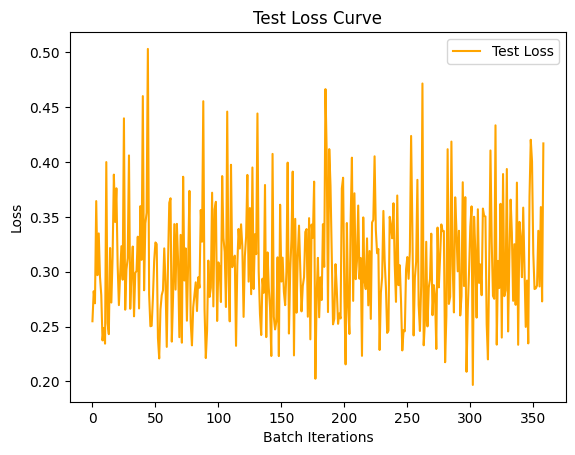

In [7]:
# Evaluation loop
model.eval()
test_losses = []
total_loss = 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        test_losses.append(loss.item())

avg_loss = total_loss / len(test_loader)
print(f"Test Loss: {avg_loss}")

# Plot the test loss curve
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel('Batch Iterations')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()
plt.show()

In [8]:
def generate_summary(text, model, tokenizer, max_length=512):
    model.eval()
    input_ids = tokenizer.encode(text, return_tensors="pt", max_length=max_length, truncation=True).to(device)

    summary_ids = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Generate summaries for all test samples
generated_summaries = []
for i in tqdm(range(len(test_df)), desc="Generating Summaries"):
    input_text = test_df.iloc[i]['extractive_summary']
    summary = generate_summary(input_text, model, tokenizer)
    generated_summaries.append(summary)

# Save the generated summaries
test_df['generated_summary'] = generated_summaries

Generating Summaries: 100%|██████████| 2871/2871 [33:53<00:00,  1.41it/s]


In [9]:
import pandas as pd
import os

# --- Assuming 'test_df' has been successfully created and populated ---
# test_df['generated_summary'] = generated_summaries
# --------------------------------------------------------------------

# 1. Define the Output File Path
# This path is standard for all Kaggle notebooks
OUTPUT_DIR = '/kaggle/working/'
OUTPUT_FILENAME = 'submission_summaries.csv'
FULL_PATH = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)

# 2. Prepare the DataFrame for Submission
# It is best practice to only save the necessary columns (e.g., ID and the generated summary).
# Assuming your original test_df has an 'id' column for mapping submissions:
submission_df = test_df[['id', 'generated_summary']].copy()

# 3. Save the DataFrame to CSV
print(f"Saving generated summaries to {FULL_PATH}")

# The index=False argument is crucial to prevent Pandas from writing
# an unwanted row index number as the first column in the CSV file.
submission_df.to_csv(FULL_PATH, index=False)

print("Save successful. The file is now available in the notebook output.")
print(f"Check the first few rows of the saved file:")
print(pd.read_csv(FULL_PATH).head())

Saving generated summaries to /kaggle/working/submission_summaries.csv
Save successful. The file is now available in the notebook output.
Check the first few rows of the saved file:
                                         id  \
0  2335b16fc91d4d87e793fa4f90ee567cfdcd20c7   
1  21668cc04a9143dd4c9aaf498fd98d4a180d0013   
2  0d85a71e7d9847ce6cc38179aae2f5580d054e3a   
3  2493439cb74e96db86e1ad075152bf688afee7d8   
4  1fe35dce98c803df6f065547c0717f06ff3e73d6   

                                   generated_summary  
0  The seven-bedroom property on Bolton Street, M...  
1  Tony Hall's wife Cynthia earns six-figure sala...  
2  Susan Atkins' request should not be sent to th...  
3  Urban Outfitters has been criticised by drugs ...  
4  Scientists at Manchester University have disco...  


Another MODEL SeqTOSeq

In [ ]:
# import pandas as pd
# import torch
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# from tqdm import tqdm
# import matplotlib.pyplot as plt # Import Matplotlib for plotting
# from torch.cuda.amp import autocast, GradScaler 

# # --- Import Fixes for Transformers Optimizers ---
# try:
#     from transformers.optimization import AdamW, get_linear_schedule_with_warmup
# except ImportError:
#     try:
#         from transformers.optimization_pytorch import AdamW, get_linear_schedule_with_warmup
#     except ImportError as e:
#         print(f"Failed to import AdamW/Scheduler. Please check your transformers installation. Error: {e}")
#         exit()
# # --------------------------------------------------

# # --- 0. DATA PREPARATION (Based on your input) ---

# # Load the dataset
# # Note: Ensure this path is correct in your Kaggle environment
# df = pd.read_csv("/kaggle/input/summarized/summarized_cnn_dailymail.csv")

# # Clean the dataset
# #df = df.dropna(subset=['extractive_summary', 'summary']) 

# # Rename columns for clarity (adjust these if your column names are different)
# df = df.rename(columns={'extractive_summary': 'article', 'summary': 'target'})

# # Split the dataset
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# print(f"Training samples: {len(train_df)}")

# # --- 1. CONFIGURATION ---
# MODEL_NAME = "facebook/bart-base" 
# MAX_SOURCE_LENGTH = 1024           
# MAX_TARGET_LENGTH = 150            
# BATCH_SIZE = 8                     
# LEARNING_RATE = 3e-5
# EPOCHS = 3
# WARMUP_RATIO = 0.1

# # 1. GPU SETUP
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if device.type == 'cuda':
#     print(f"Using GPU: {torch.cuda.get_device_name(0)}")
# else:
#     print("Using CPU: CUDA not available.")


# # --- 2. MODEL AND TOKENIZER LOADING ---

# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
# model.to(device)


# # --- 3. CUSTOM DATASET CLASS (No changes) ---

# class SummaryDataset(Dataset):
#     def __init__(self, dataframe, tokenizer, source_max_len, target_max_len):
#         self.tokenizer = tokenizer
#         self.dataframe = dataframe
#         self.source_max_len = source_max_len
#         self.target_max_len = target_max_len

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, index):
#         data = self.dataframe.iloc[index]
#         source_text = str(data['article'])
#         target_text = str(data['target'])

#         source_tokenized = self.tokenizer(
#             source_text,
#             max_length=self.source_max_len,
#             padding="max_length",
#             truncation=True,
#             return_tensors="pt"
#         )

#         target_tokenized = self.tokenizer(
#             target_text,
#             max_length=self.target_max_len,
#             padding="max_length",
#             truncation=True,
#             return_tensors="pt"
#         )
        
#         labels = target_tokenized['input_ids'].squeeze()
#         labels[labels == self.tokenizer.pad_token_id] = -100

#         return {
#             'input_ids': source_tokenized['input_ids'].squeeze(),
#             'attention_mask': source_tokenized['attention_mask'].squeeze(),
#             'labels': labels
#         }

# # Create Dataset and DataLoader
# train_dataset = SummaryDataset(train_df, tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


# # --- 4. OPTIMIZER AND SCHEDULER SETUP ---

# total_steps = len(train_loader) * EPOCHS
# warmup_steps = int(total_steps * WARMUP_RATIO)

# optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=warmup_steps,
#     num_training_steps=total_steps
# )


# # --- 5. TRAINING LOOP WITH LOSS RECORDING ---

# scaler = GradScaler() 

# def train(model, data_loader, optimizer, scheduler, device, epochs):
#     model.train()
    
#     # New: List to store the average loss for each epoch
#     epoch_losses = [] 
    
#     for epoch in range(epochs):
#         total_loss = 0
        
#         for batch in tqdm(data_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
#             optimizer.zero_grad()

#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['labels'].to(device)

#             # AMP FORWARD PASS
#             with autocast():
#                 outputs = model(
#                     input_ids=input_ids, 
#                     attention_mask=attention_mask, 
#                     labels=labels
#                 )
#                 loss = outputs.loss
            
#             # AMP SCALING AND BACKWARD PASS
#             scaler.scale(loss).backward()
#             scaler.unscale_(optimizer) 
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
#             scaler.step(optimizer)
#             scaler.update()
            
#             scheduler.step()
            
#             total_loss += loss.item()

#         avg_loss = total_loss / len(data_loader)
#         epoch_losses.append(avg_loss) # Store the average loss for the epoch
        
#         print(f"\n--- Epoch {epoch + 1} Complete. Average Loss: {avg_loss:.4f} ---")

#     print("\nTraining complete!")
#     return epoch_losses # Return the list of losses


# # Execute the training function and capture the loss data
# training_losses = train(model, train_loader, optimizer, scheduler, device, EPOCHS)


# # --- 6. PLOT THE LOSS CURVE ---

# plt.figure(figsize=(8, 5))
# plt.plot(range(1, EPOCHS + 1), training_losses, marker='o', linestyle='-', color='blue')
# plt.title('Training Loss per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Average Loss')
# plt.xticks(range(1, EPOCHS + 1)) # Ensure x-axis ticks match epoch numbers
# plt.grid(True)
# plt.show() # 

# # --- 7. SAVE THE MODEL ---
# OUTPUT_MODEL_DIR = "/kaggle/working/fine_tuned_summarizer"

# with torch.no_grad():
#     model.cpu()
#     model.save_pretrained(OUTPUT_MODEL_DIR)

# tokenizer.save_pretrained(OUTPUT_MODEL_DIR)
# print(f"\nModel saved to: {OUTPUT_MODEL_DIR}")

BERT TO BERT


In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    EncoderDecoderModel,
    Adafactor
)
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler

2025-12-15 11:48:50.952111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765799331.139528      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765799331.189246      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [13]:
# --- 0. DATA PREPARATION ---
df = pd.read_csv("/kaggle/input/summarized/summarized_cnn_dailymail.csv")

# Use correct columns for abstractive summarization
df = df.dropna(subset=["article", "highlights"])
df = df.rename(columns={"highlights": "target"})

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

# --- 1. CONFIGURATION ---
ENCODER_MODEL_NAME = "bert-base-uncased"
DECODER_MODEL_NAME = "bert-base-uncased"

MAX_SOURCE_LENGTH = 512
MAX_TARGET_LENGTH = 150
BATCH_SIZE = 8
EPOCHS = 3

# --- GPU SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Training samples: 11484
Testing samples: 2871
Using GPU: Tesla P100-PCIE-16GB


In [22]:
# --- 2. TOKENIZER & MODEL ---
tokenizer = AutoTokenizer.from_pretrained(ENCODER_MODEL_NAME)

model = EncoderDecoderModel.from_encoder_decoder_pretrained(
    ENCODER_MODEL_NAME,
    DECODER_MODEL_NAME
)

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.encoder.vocab_size

# Generation configuration
model.config.max_length = MAX_TARGET_LENGTH
model.config.min_length = 30
model.config.no_repeat_ngram_size = 3
model.config.num_beams = 4

# Add BOS/EOS tokens if missing
if tokenizer.bos_token is None:
    tokenizer.add_special_tokens({'bos_token': '[CLS]', 'eos_token': '[SEP]'})

    # Resize embeddings separately for encoder and decoder
    model.encoder.resize_token_embeddings(len(tokenizer))
    model.decoder.resize_token_embeddings(len(tokenizer))

# Move model to GPU AFTER resizing
model.to(device)

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [23]:
# --- 3. DATASET ---
class SummaryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_max_len, target_max_len):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.source_max_len = source_max_len
        self.target_max_len = target_max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        article = str(self.df.loc[idx, "article"])
        target = str(self.df.loc[idx, "target"])

        source_enc = self.tokenizer(
            article,
            max_length=self.source_max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target_enc = self.tokenizer(
            target,
            max_length=self.target_max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        labels = target_enc["input_ids"].squeeze()
        labels[labels == tokenizer.pad_token_id] = -100

        return {
            "input_ids": source_enc["input_ids"].squeeze(),
            "attention_mask": source_enc["attention_mask"].squeeze(),
            "labels": labels
        }

train_dataset = SummaryDataset(train_df, tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [24]:
# --- 4. ADAFACTOR OPTIMIZER (CORRECT USAGE) ---
optimizer = Adafactor(
    model.parameters(),
    lr=None,                  # DO NOT set lr manually
    scale_parameter=True,
    relative_step=True,
    warmup_init=True,
    weight_decay=0.01
)

# --- 5. TRAINING LOOP ---
scaler = GradScaler()

def train(model, loader, optimizer, device, epochs):
    model.train()
    losses = []

    for epoch in range(epochs):
        total_loss = 0.0

        for batch in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        print(f"\nEpoch {epoch+1} | Average Loss: {avg_loss:.4f}")

    return losses

training_losses = train(model, train_loader, optimizer, device, EPOCHS)


/tmp/ipykernel_47/1292747028.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/3:   0%|          | 0/1436 [00:00<?, ?it/s]/tmp/ipykernel_47/1292747028.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:557: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to trai


Epoch 1 | Average Loss: 5.4371


Epoch 2/3: 100%|██████████| 1436/1436 [21:00<00:00,  1.14it/s]



Epoch 2 | Average Loss: 4.3190


Epoch 3/3: 100%|██████████| 1436/1436 [20:59<00:00,  1.14it/s]


Epoch 3 | Average Loss: 3.9013


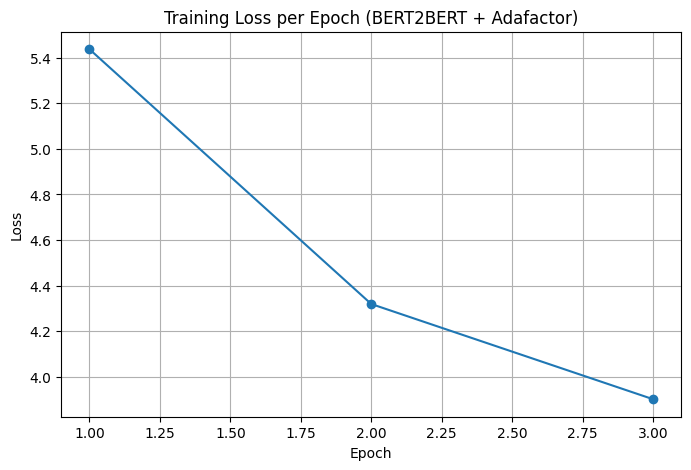

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 150, 'min_length': 30, 'num_beams': 4, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



Model saved to: /kaggle/working/fine_tuned_bert2bert_abstractive


In [25]:
# --- 6. PLOT LOSS ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), training_losses, marker="o")
plt.title("Training Loss per Epoch (BERT2BERT + Adafactor)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# --- 7. SAVE MODEL ---
OUTPUT_DIR = "/kaggle/working/fine_tuned_bert2bert_abstractive"

model.cpu()
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print(f"\nModel saved to: {OUTPUT_DIR}")


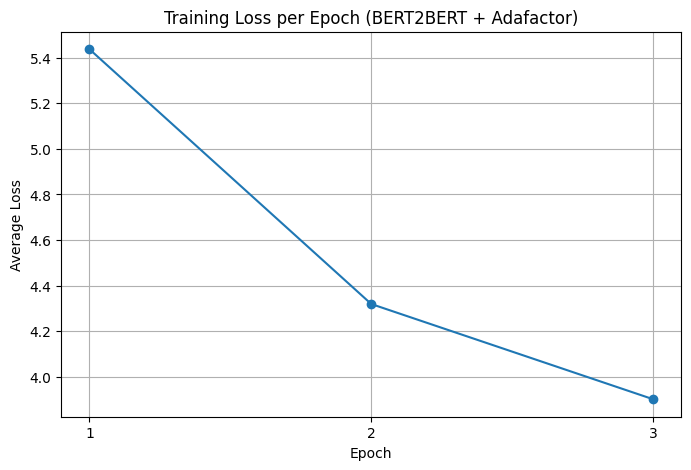

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), training_losses, marker='o', linestyle='-')
plt.title("Training Loss per Epoch (BERT2BERT + Adafactor)")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.xticks(range(1, EPOCHS+1))
plt.grid(True)
plt.show()


In [ ]:
# def evaluate(model, data_loader, device):
#     model.eval()
#     total_loss = 0.0

#     with torch.no_grad():
#         for batch in data_loader:
#             input_ids = batch["input_ids"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
#             labels = batch["labels"].to(device)

#             outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss

#             total_loss += loss.item()

#     avg_loss = total_loss / len(data_loader)
#     return avg_loss

# test_loss = evaluate(model, test_loader, device)
# print(f"Test Loss: {test_loss:.4f}")


RAG

In [55]:
# --- 1. IMPORTS ---
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import RagTokenizer, RagRetriever, RagSequenceForGeneration, Adafactor
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

# --- 1. LOAD DATA ---
df = pd.read_csv("/kaggle/input/summarized/summarized_cnn_dailymail.csv")
df = df.dropna(subset=['article', 'highlights'])
df = df.rename(columns={'highlights': 'target'})

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

# --- 2. DEVICE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# --- Important Fix ---
# model.generator.to(device)          # Explicitly move generator to GPU
# model.question_encoder.to(device)   # Explicitly move question encoder to GPU

# --- 3. TOKENIZER ---
model_name = "facebook/rag-token-nq"
tokenizer = RagTokenizer.from_pretrained(model_name)

# Add pad token to underlying tokenizers if missing
if tokenizer.generator.pad_token is None:
    tokenizer.generator.add_special_tokens({'pad_token': '[PAD]'})
if tokenizer.question_encoder.pad_token is None:
    tokenizer.question_encoder.add_special_tokens({'pad_token': '[PAD]'})

print("Generator pad_token_id:", tokenizer.generator.pad_token_id)
print("Question encoder pad_token_id:", tokenizer.question_encoder.pad_token_id)


Train samples: 11484, Test samples: 2871


AttributeError: 'EncoderDecoderModel' object has no attribute 'generator'

In [51]:
## --- 4. RETRIEVER AND MODEL ---
retriever = RagRetriever.from_pretrained(
    model_name,
    index_name="exact",
    passages=None,
    use_dummy_dataset=True  # placeholder dataset for small-scale/fine-tuning
)

model = RagSequenceForGeneration.from_pretrained(model_name, retriever=retriever)

# --- Important Fix: move all parts to same device ---
model.to(device)
model.generator.to(device)
model.question_encoder.to(device)

# Resize embeddings for new pad tokens
model.generator.resize_token_embeddings(len(tokenizer.generator))
model.question_encoder.resize_token_embeddings(len(tokenizer.question_encoder))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

ImportError: 
CanonicalHFIndex requires the faiss library but it was not found in your environment. Check out the instructions on the
installation page of its repo: https://github.com/facebookresearch/faiss/blob/master/INSTALL.md and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [52]:
# --- 5. DATASET CLASS ---
class SummarizationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_input_len=512, max_target_len=150):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        article = str(self.df.loc[idx, "article"])
        target = str(self.df.loc[idx, "target"])

        input_enc = self.tokenizer(
            article,
            truncation=True,
            padding="max_length",
            max_length=self.max_input_len,
            return_tensors="pt"
        )
        target_enc = self.tokenizer(
            target,
            truncation=True,
            padding="max_length",
            max_length=self.max_target_len,
            return_tensors="pt"
        )

        labels = target_enc["input_ids"].squeeze()
        labels[labels == tokenizer.generator.pad_token_id] = -100  # ignore padding

        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": labels
        }

train_dataset = SummarizationDataset(train_df, tokenizer)
test_dataset = SummarizationDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [53]:
# --- 6. OPTIMIZER ---
optimizer = Adafactor(
    model.parameters(),
    lr=None,
    scale_parameter=True,
    relative_step=True,
    warmup_init=True,
    weight_decay=0.01
)
scaler = GradScaler()


/tmp/ipykernel_47/3327191469.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [54]:

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            with autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                total_loss += outputs.loss.item()
    return total_loss / len(loader)


EPOCHS = 1  # change to 3 or more for full training
training_losses = []
test_losses = []

for epoch in range(EPOCHS):
    # Training
    model.train()
    total_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()

        # Move all input tensors to the same device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Evaluation
    avg_test_loss = evaluate(model, test_loader, device)
    test_losses.append(avg_test_loss)

    print(f"\nEpoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")


Epoch 1/1:   0%|          | 0/5742 [00:00<?, ?it/s]/tmp/ipykernel_47/2483193349.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/1:   0%|          | 0/5742 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [42]:
# --- 8. PLOT LOSS ---
plt.figure(figsize=(8,5))
plt.plot(range(1,EPOCHS+1), training_losses, marker='o', label='Training Loss')
plt.plot(range(1,EPOCHS+1), test_losses, marker='x', label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss (RAG)")
plt.xticks(range(1,EPOCHS+1))
plt.grid(True)
plt.legend()
plt.show()

# --- 9. SAVE MODEL ---
OUTPUT_DIR = "/kaggle/working/fine_tuned_rag_summarizer"
model.cpu()
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Model saved to: {OUTPUT_DIR}")

Token indices sequence length is longer than the specified maximum sequence length for this model (908 > 512). Running this sequence through the model will result in indexing errors


ValueError: `decoder_start_token_id` or `bos_token_id` has to be defined for encoder-decoder generation.

In [56]:
# --- 0. IMPORTS ---
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import RagTokenizer, RagRetriever, RagSequenceForGeneration, Adafactor
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- 1. LOAD DATA ---
df = pd.read_csv("/kaggle/input/summarized/summarized_cnn_dailymail.csv")
df = df.dropna(subset=['article', 'highlights'])
df = df.rename(columns={'highlights': 'target'})

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

# --- 2. DEVICE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- 3. TOKENIZER ---
model_name = "facebook/rag-token-nq"
tokenizer = RagTokenizer.from_pretrained(model_name)

# Add pad token to underlying tokenizers if missing
if tokenizer.generator.pad_token is None:
    tokenizer.generator.add_special_tokens({'pad_token': '[PAD]'})
if tokenizer.question_encoder.pad_token is None:
    tokenizer.question_encoder.add_special_tokens({'pad_token': '[PAD]'})

print("Generator pad_token_id:", tokenizer.generator.pad_token_id)
print("Question encoder pad_token_id:", tokenizer.question_encoder.pad_token_id)

# --- 4. RETRIEVER AND MODEL ---
retriever = RagRetriever.from_pretrained(
    model_name,
    index_name="exact",
    passages=None,
    use_dummy_dataset=True  # placeholder dataset for small-scale/fine-tuning
)

model = RagSequenceForGeneration.from_pretrained(model_name, retriever=retriever)

# --- Important Fix: move all parts to same device ---
model.to(device)
model.generator.to(device)
model.question_encoder.to(device)

# Resize embeddings for new pad tokens
model.generator.resize_token_embeddings(len(tokenizer.generator))
model.question_encoder.resize_token_embeddings(len(tokenizer.question_encoder))

# --- 5. DATASET CLASS ---
class SummarizationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_input_len=512, max_target_len=150):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        article = str(self.df.loc[idx, "article"])
        target = str(self.df.loc[idx, "target"])

        input_enc = self.tokenizer(
            article,
            truncation=True,
            padding="max_length",
            max_length=self.max_input_len,
            return_tensors="pt"
        )
        target_enc = self.tokenizer(
            target,
            truncation=True,
            padding="max_length",
            max_length=self.max_target_len,
            return_tensors="pt"
        )

        labels = target_enc["input_ids"].squeeze()
        labels[labels == tokenizer.generator.pad_token_id] = -100  # ignore padding

        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": labels
        }

train_dataset = SummarizationDataset(train_df, tokenizer)
test_dataset = SummarizationDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# --- 6. OPTIMIZER ---
optimizer = Adafactor(
    model.parameters(),
    lr=None,
    scale_parameter=True,
    relative_step=True,
    warmup_init=True,
    weight_decay=0.01
)
scaler = GradScaler()



Train samples: 11484, Test samples: 2871
Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in

Generator pad_token_id: 1
Question encoder pad_token_id: 0


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

ImportError: 
CanonicalHFIndex requires the faiss library but it was not found in your environment. Check out the instructions on the
installation page of its repo: https://github.com/facebookresearch/faiss/blob/master/INSTALL.md and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


Epoch 1/1:   0%|          | 0/5742 [00:00<?, ?it/s]/tmp/ipykernel_47/1112220575.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:557: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model traine


Epoch 1 | Train Loss: 1.8283 | Test Loss: 2.2051


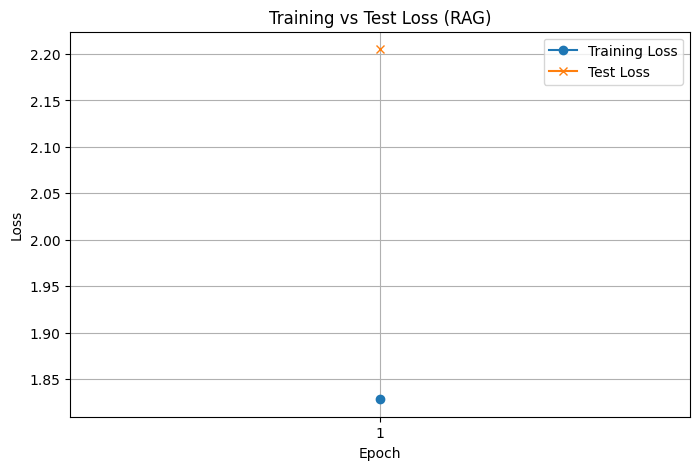

Model saved to: /kaggle/working/fine_tuned_rag_summarizer


In [57]:

# --- 7. TRAINING AND EVALUATION FUNCTIONS ---
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                total_loss += outputs.loss.item()
    return total_loss / len(loader)

EPOCHS = 1  # increase to 3+ for full training
training_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    avg_test_loss = evaluate(model, test_loader, device)
    test_losses.append(avg_test_loss)

    print(f"\nEpoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

# --- 8. PLOT LOSS ---
plt.figure(figsize=(8,5))
plt.plot(range(1,EPOCHS+1), training_losses, marker='o', label='Training Loss')
plt.plot(range(1,EPOCHS+1), test_losses, marker='x', label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss (RAG)")
plt.xticks(range(1,EPOCHS+1))
plt.grid(True)
plt.legend()
plt.show()

# --- 9. SAVE MODEL ---
OUTPUT_DIR = "/kaggle/working/fine_tuned_rag_summarizer"
model.cpu()
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Model saved to: {OUTPUT_DIR}")
